In [141]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

## **Class implementation**

In [142]:
def fitness_queens_individual(individual: list[int]):
    """Calculates the number of conflict queens in the individual's configuration"""

    L = len(individual)
    bad_queens = 0
    for x in range(L):
        if individual.count(individual[x]) > 1: # other queen in the same row
            bad_queens += 1
            continue
        for y in range(L):
            if x == y: # same queen doesn´t count
                continue
            if abs(individual[x] - individual[y]) == abs(x - y):
                bad_queens += 1
                break
    return bad_queens

In [ ]:
class AG_N_reinas():
    def __init__(self, N: int):
        """Create the population"""

        self.population = []
        self.fitnesses = []
        for i in range(N):
            individual = [i for i in range(N)]
            random.shuffle(individual)
            self.population.append(individual)

    def sort_pop(self, fitness_function, reverse_sort: bool) -> tuple[list[list], list]:
        """Sort population by fitness function. Return tuple with population list and fitness list"""

        fitness_list = [fitness_function(ind) for ind in self.population]
        lista = sorted(zip(self.population, fitness_list), key=lambda x: x[1], reverse=reverse_sort)
        self.population = [x[0] for x in lista]
        self.fitnesses = [x[1] for x in lista]
    
    def select(self, T: int) -> list[list]:
        """Return a copy of an indivudual by tournament selection. Population already ordered by fitness"""

        choices=random.choices(copy.copy(self.population), k=T)
        indices=[self.population.index(c) for c in choices]
        return self.population[np.argmin(indices)]
    
    def crossover(self, parent1: list, parent2: list, pcross: float) -> tuple[list, list]:
        """Performs crossover on two parents to generate two children."""
        
        child1, child2 = [], []
        for i in range(len(parent1)):
            if random.random()<pcross:
                if parent1[i] not in child1:
                    child1.append(parent1[i])
                else:
                    child1.append(parent2[i])
                if parent2[i] not in child2:
                    child2.append(parent2[i])
                else:
                    child2.append(parent1[i])
            else:
                if parent2[i] not in child1:
                    child1.append(parent2[i])
                else:
                    child1.append(parent1[i])
                if parent1[i] not in child2:
                    child2.append(parent1[i])
                else:
                    child2.append(parent2[i])
        return child1,child2

    def mutate(self, individual: list[list], pmut: float) -> list:
        """Mutate an individual, swap elements. Return mutated individual"""
    
        def mutate_swap(individual: list[list], pmut: float) -> list[list]:
            if random.random() < pmut:
                index1, index2 = random.choices(range(len(individual)), k=2)
                individual[index1], individual[index2] = individual[index2], individual[index1]
            return individual

        def mutate_insert(individual: list[list], pmut: float) -> list[list]:
            if random.random() < pmut:
                index_pop, index_insert = random.choices(range(len(individual)), k=2)
                value = individual.pop(index_pop)
                individual.insert(index_insert, value)
            return individual

        def mutate_reverse(individual: list[list], pmut: float) -> list[list]: 
            if random.random() < pmut:
                index1, index2 = sorted(random.sample(range(len(individual)), 2))
                individual[index1:index2 + 1] = individual[index1:index2 + 1][::-1]
            return individual
        
        mutations = [mutate_swap, mutate_insert, mutate_reverse]
        operator = random.choice(mutations)
        return operator(individual, pmut)

    def evolve(self, fitness_function, pmut=0.1, pcross=0.7, ngen=100, T=2, trace=50, reverse_sort=False, elitism=False) -> None:
        """Evolution procedure. Initial population already created"""

        for i in range(ngen):
            new_pop = []
            self.sort_pop(fitness_function, reverse_sort)
            if elitism:
                new_pop.append(self.population[0])
                new_pop.append(self.population[1])
            while len(new_pop) != 100:   
                individual1 = self.select(T)
                individual2 = self.select(T)
                child1, child2 = self.crossover(individual1, individual2, pcross)
                mutated1 = self.mutate(child1, pmut)
                mutated2 = self.mutate(child2, pmut)
                new_pop.append(mutated1)
                new_pop.append(mutated2)
                
            self.population = [*new_pop] # make a copy

            if i % trace == 0 or i == ngen-1: # en la última gen se ordena
                self.sort_pop(fitness_function, reverse_sort)
                print(f"Nº gen: {i}, Best ind: {self.population[0]}, Best fitness: {self.fitnesses[0]}")

## **Visual test**

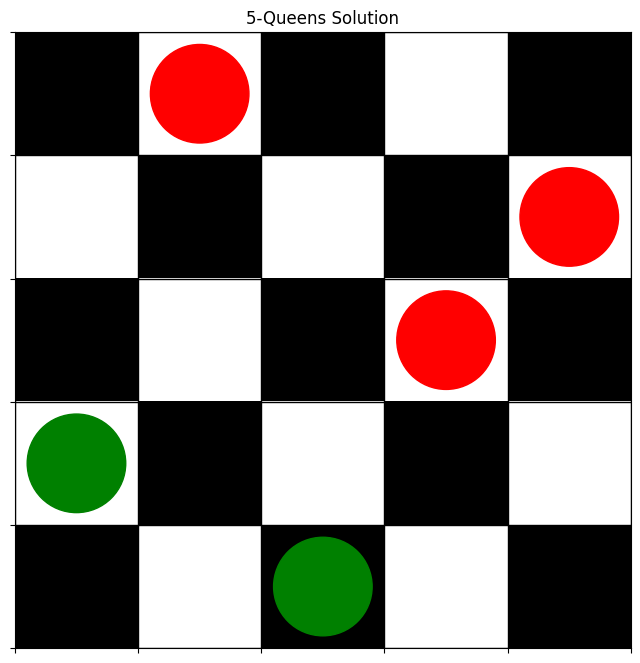

In [ ]:
def draw_solution(tablero: list[int]):
    def check_conflicts(tablero: list[int], column: int, row: int) -> bool:
        for c, r in enumerate(tablero):
            if c == column:
                continue  # Skip the current queen
            # Check for column or diagonal conflicts
            if r == row or abs(c - column) == abs(r - row):
                return True
        return False
    
    n = len(tablero)
    fig, ax = plt.subplots(figsize=(8, 8))
    
    board = np.zeros((n, n))
    for row in range(n):
        for col in range(n):
            board[row, col] = (row + col) % 2  # Alternate white (0) and gray (1)
    ax.imshow(board, cmap="gray", extent=(0, n, 0, n))

    for col, row in enumerate(tablero):
        queen_color = "green" if not check_conflicts(tablero, col, row) else "red"
        circle = plt.Circle((col + 0.5, n - row - 0.5), 0.4, color=queen_color, ec="black")
        ax.add_patch(circle)

    ax.grid(color="black", linestyle="-", linewidth=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(f"{n}-Queens Solution")
    plt.show()
# -----------------------------------------
solution = [3, 0, 4, 2, 1]
draw_solution(solution)

## **---------------------------Tests---------------------------**

Nº gen: 0, Best ind: [4, 0, 1, 2, 7, 5, 3, 6], Best fitness: 4
Nº gen: 99, Best ind: [4, 2, 7, 3, 6, 0, 5, 1], Best fitness: 0
*******Tiempo evolución: 0 minutos y 0.14 segundos*******


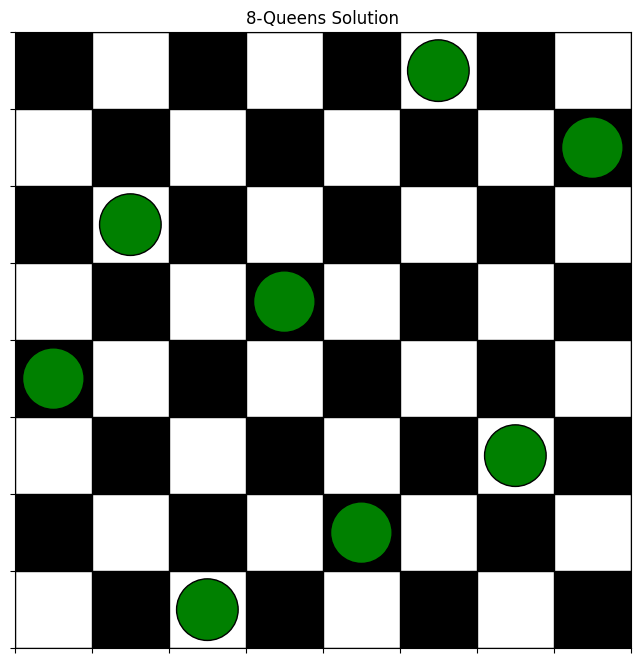

In [145]:
N = 8 # tablero NxN
genetic_algorithm = AG_N_reinas(N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_queens_individual, pmut=0.1, ngen=100, T=6, trace=100)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

draw_solution(genetic_algorithm.population[0])

Nº gen: 0, Best ind: [12, 15, 11, 7, 0, 6, 3, 10, 14, 4, 2, 9, 13, 1, 5, 8], Best fitness: 6
Nº gen: 100, Best ind: [5, 15, 13, 7, 3, 6, 0, 10, 14, 4, 2, 9, 12, 1, 11, 8], Best fitness: 0
Nº gen: 200, Best ind: [5, 15, 13, 7, 3, 6, 0, 10, 14, 4, 2, 9, 12, 1, 11, 8], Best fitness: 0
Nº gen: 299, Best ind: [5, 15, 13, 7, 3, 6, 0, 10, 14, 4, 2, 9, 12, 1, 11, 8], Best fitness: 0
*******Tiempo evolución: 0 minutos y 0.87 segundos*******


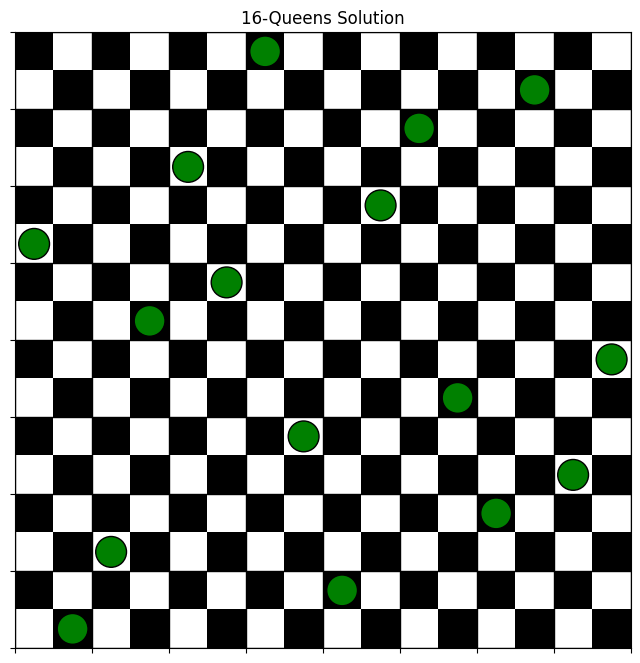

In [149]:
N = 16 # tablero NxN
genetic_algorithm = AG_N_reinas(N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_queens_individual, pmut=0.1, ngen=300, T=6, trace=100)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

draw_solution(genetic_algorithm.population[0])

Nº gen: 0, Best ind: [26, 9, 3, 10, 15, 18, 30, 16, 8, 11, 31, 27, 5, 7, 20, 0, 28, 4, 2, 1, 24, 21, 17, 22, 23, 25, 29, 12, 14, 19, 13, 6], Best fitness: 17
Nº gen: 250, Best ind: [26, 9, 25, 8, 15, 2, 24, 16, 10, 19, 14, 27, 5, 7, 20, 0, 28, 4, 18, 3, 12, 29, 11, 22, 31, 23, 21, 30, 1, 17, 13, 6], Best fitness: 2
Nº gen: 500, Best ind: [26, 9, 25, 8, 15, 2, 24, 16, 10, 19, 14, 27, 5, 7, 20, 0, 28, 4, 18, 3, 12, 29, 11, 22, 31, 23, 21, 30, 1, 17, 13, 6], Best fitness: 2
Nº gen: 750, Best ind: [26, 9, 25, 8, 15, 2, 24, 16, 10, 22, 14, 27, 5, 7, 20, 0, 28, 4, 18, 3, 19, 11, 29, 12, 31, 23, 21, 30, 1, 17, 13, 6], Best fitness: 2
Nº gen: 999, Best ind: [26, 9, 31, 8, 15, 2, 24, 16, 10, 22, 14, 27, 5, 7, 20, 0, 28, 4, 18, 3, 19, 11, 29, 12, 25, 23, 21, 30, 1, 17, 13, 6], Best fitness: 0
*******Tiempo evolución: 0 minutos y 9.32 segundos*******


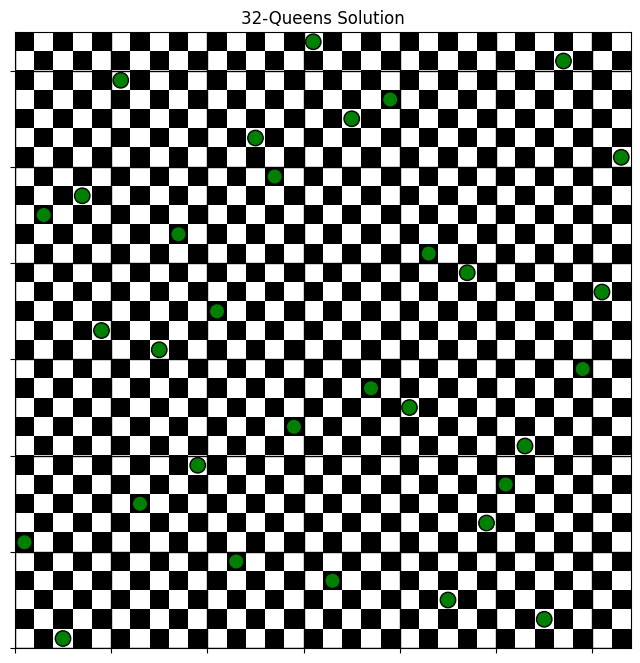

In [147]:
N = 32 # tablero NxN
genetic_algorithm = AG_N_reinas(N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_queens_individual, pmut=0.1, ngen=1000, T=6, trace=250)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

draw_solution(genetic_algorithm.population[0])

Nº gen: 0, Best ind: [47, 26, 21, 23, 7, 15, 13, 44, 56, 6, 8, 36, 31, 14, 49, 41, 35, 0, 10, 11, 20, 2, 34, 24, 18, 43, 22, 54, 45, 57, 28, 27, 30, 48, 59, 12, 63, 55, 46, 29, 52, 33, 42, 16, 53, 61, 39, 58, 9, 51, 40, 62, 1, 37, 17, 60, 38, 19, 4, 25, 50, 5, 3, 32], Best fitness: 39
Nº gen: 250, Best ind: [34, 14, 21, 23, 42, 15, 13, 44, 56, 33, 8, 63, 35, 41, 49, 1, 31, 0, 62, 18, 10, 12, 47, 24, 28, 43, 22, 54, 45, 59, 2, 11, 27, 25, 48, 20, 36, 16, 46, 6, 4, 29, 7, 55, 53, 61, 39, 58, 9, 51, 50, 57, 26, 37, 17, 60, 38, 19, 52, 30, 40, 5, 3, 32], Best fitness: 9
Nº gen: 500, Best ind: [34, 14, 21, 23, 42, 15, 13, 44, 56, 33, 8, 63, 35, 41, 49, 1, 5, 0, 62, 18, 10, 12, 47, 24, 28, 43, 22, 54, 45, 59, 2, 60, 27, 25, 48, 20, 36, 16, 46, 6, 4, 29, 7, 55, 53, 61, 39, 58, 9, 50, 51, 11, 26, 37, 17, 57, 38, 19, 52, 30, 40, 31, 3, 32], Best fitness: 4
Nº gen: 750, Best ind: [34, 14, 21, 23, 42, 15, 13, 44, 56, 33, 8, 63, 27, 41, 49, 1, 5, 0, 62, 18, 10, 12, 47, 24, 28, 43, 22, 54, 45, 59, 

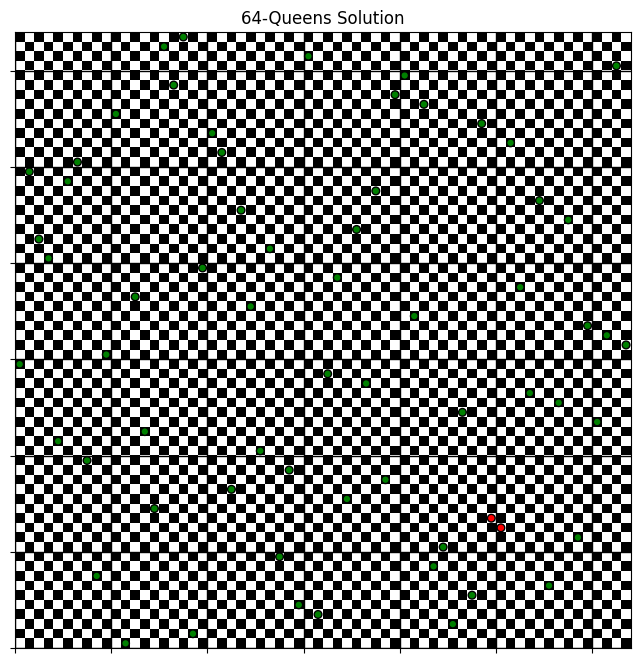

In [151]:
N = 64 # tablero NxN
genetic_algorithm = AG_N_reinas(N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_queens_individual, pmut=0.1, ngen=1000, T=6, trace=250)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

draw_solution(genetic_algorithm.population[0])